# AnimeGM - Autoencoder - Keras
GOAL: Generate new anime-style images

View model: `$ tensorboard --logdir=autoencoder`

Methodology:
1. Build a dataset of images suitable for out needs
2. Build a generative model.
3. Train the model
4. Transfer style to a photo

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, data, transform
import seaborn as sns; sns.set()
from os import listdir, path
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape, UpSampling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, TensorBoard
%matplotlib inline

Using TensorFlow backend.


### Functions

In [2]:
# tf image preprocessing
# load, decoded and resize
def parse_image(flatten, n_channels, path, resize_dim):
    """parses an image and converts it to the type we want.
    flatten: to flatten the image into a vector or not.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    path: path to the image.
    resize_dim: the number of pixels the image should be per size.
    
    return: the image as a vector or matrix
    """
    
    image_string = tf.read_file(path)
    
    # decode
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = tf.image.rgb_to_grayscale(image)
        
    # resize the image
    image = tf.image.resize_images(image, [resize_dim, resize_dim])
    
    # feature normalize the image
    image = tf.divide(image, 255)
    
    # check if we want the image flattened
    # if so, flatten the image
    if flatten == True:
        image = tf.reshape(image, [-1])
    
    return image

In [3]:
def data_generator(paths, iter, mode, sess):   
    """Creates a data generator.
    paths: image paths to feed the generator with.
    iter: TF dataset iterator.
    mode: the mode we want (train or test).
    sess: instance of a TF session.
    
    return: an image batch
    """
    
    next_batch = iter.get_next()
    
    # Initialize an iterator over a dataset.
    sess.run(iter.initializer, feed_dict={image_paths: paths})

    # yield the next batch
    while 1:
        batch = sess.run(next_batch)
        
        # check for mode
        if mode == 'train':
            result = batch, batch
        elif mode == 'test':
            result = batch
            
        yield result

In [4]:
def show_image(image, n_channels, resize_dim):
    """Shows an image.
    image: image data to show.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    resize_dim: the number of pixels the image should be per size.
    """
    
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = image.reshape((resize_dim, resize_dim))
    else:
        image = image.reshape((resize_dim, resize_dim, n_channels))

    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
def show_images(images, n_channels, resize_dim):
    """Shows a set of images.
    images: a set of image data to show.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    resize_dim: the number of pixels the image should be per size.
    """
    
   # get the number of images
    n_images = images.shape[0]
    
    if n_images == 1:
        show_image(images[0], n_channels, resize_dim)
        return
    
    # get the square root of the number of images
    squareroot = int(np.ceil(np.sqrt(n_images)))
    
    # size of the figure
    figsize = (10, 10)
    
    # configure subplots
    fig, ax = plt.subplots(squareroot, squareroot, figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, axi in enumerate(ax.flat):
        # exit if the index of subplots is greater than amount of images
        if i > n_images - 1:
            return
        
        image = images[i]
        
        # check for 1 channel
        # if so, grayscale
        if (n_channels == 1):
            image = image.reshape((resize_dim, resize_dim))
        else:
            image = image.reshape((resize_dim, resize_dim, n_channels))

        im = axi.imshow(image, cmap='gray')

In [6]:
def gray_scale_resize(image, resize_dim):
    """Gray scales an image and resizes it aswell.
    image: image data.
    resize_dim: new image dimension.
    
    return grayscaled, resized image
    """
    # convert image to grayscale
    gray_image = color.rgb2gray(image)
    
    # Resize the image
    resized_image = transform.resize(gray_image, (resize_dim, resize_dim))
    
    return resized_image

### Variables

In [7]:
# data dir
dir_name = 'danbooru-small'

# log dir
log_dir = 'log'

# checkpoint path
checkpoint_path = 'checkpoints/weights.best.hdf5'

In [8]:
# number of training or test examples
n_train = 2200
n_test = 10

In [9]:
# data manipulation
resize_dim = 64
n_channels = 1
n_features = resize_dim * resize_dim * n_channels

# model 
flatten = False

In [27]:
# hyper parameters~~~~
batch_size = 100
n_batches = int(n_train / batch_size)
n_epochs = 3

cnn_dim = int(resize_dim / 2 / 2 / 2)

## 1. Build a dataset
Pull in an existing dataset and modify it for my needs.

Lets start with the danbooru 2017 anime image dataset. Now this dataset is huge. So we are only going to use 1 torrent of the SFW subset.

### Prepare data

In [11]:
# get filenames and join paths as np array
base_filenames = listdir(dir_name)
filename_paths = [path.join(dir_name, base_filename) for base_filename in base_filenames]
filename_paths = np.array(filename_paths)

In [12]:
# create paths for train and test
train_paths = filename_paths[:-n_test][:n_train]
test_paths = filename_paths[:n_test]

### Create dataset

In [13]:
# create a placeholder for image_paths
image_paths = tf.placeholder(tf.string, shape=[None])

# create a dataset from the paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(lambda image_paths: parse_image(flatten, n_channels, image_paths, resize_dim))
dataset = dataset.shuffle(buffer_size=n_train)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

# iterators
iter = dataset.make_initializable_iterator()

## 2. Build a generative model
Lets build an autoencoder

In [14]:
# input placeholder
inputs = Input(shape=(resize_dim, resize_dim, n_channels))

# encoded the input with convolutions and pooling
x = Conv2D(100, (3, 3), activation='relu', name='encoder_0', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same', name='pool_0')(x)
x = Conv2D(100, (3, 3), activation='relu', name='encoder_1', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool_1')(x)
x = Conv2D(100, (3, 3), activation='relu', name='encoder_2', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='pool_2')(x)

# decoded the compression and upsampling
x = Conv2D(100, (3, 3), activation='relu', name='decoder_0', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_0')(x)
x = Conv2D(100, (3, 3), activation='relu', name='decoder_1', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_1')(x)
decoded = Conv2D(n_channels, (3, 3), activation='sigmoid', name='decoder_2', padding='same')(x)

### Compile the model with cost and optimizer

In [15]:
# this model maps inputs to its reconstructions
autoencoder = Model(inputs, decoded)

In [16]:
# load model weights if they exist
if path.isfile(checkpoint_path):
    autoencoder.load_weights(checkpoint_path)

In [17]:
autoencoder.compile(loss='binary_crossentropy', 
                    optimizer='adadelta')

## 3. Train the model

In [28]:
# create a session to use the graph
sess = tf.Session()

# create instances of the generator
training_batch_generator = data_generator(train_paths, iter, 'train', sess)
validation_batch_generator = data_generator(train_paths, iter, 'train', sess)
test_batch_generator = data_generator(test_paths, iter, 'test', sess)
 
# create checkpoint for weights
checkpoint = ModelCheckpoint(checkpoint_path, verbose=1, 
                             save_best_only=True, save_weights_only=True,
                             monitor='val_loss', mode='min')

# train
autoencoder.fit_generator(training_batch_generator, 
                          steps_per_epoch=n_batches,
                          epochs=n_epochs,
                          validation_data=validation_batch_generator,
                          validation_steps=1,
                          callbacks=[checkpoint, TensorBoard(log_dir=log_dir)])

Epoch 1/3
22/22 [==============================] - 326s 15s/step - loss: 0.3589 - val_loss: 0.3941

Epoch 00001: val_loss improved from inf to 0.39415, saving model to checkpoints/weights.best.hdf5
Epoch 2/3
22/22 [==============================] - 274s 12s/step - loss: 0.3558 - val_loss: 0.3293

Epoch 00002: val_loss improved from 0.39415 to 0.32929, saving model to checkpoints/weights.best.hdf5
Epoch 3/3
22/22 [==============================] - 289s 13s/step - loss: 0.3811 - val_loss: 0.3503

Epoch 00003: val_loss did not improve from 0.32929


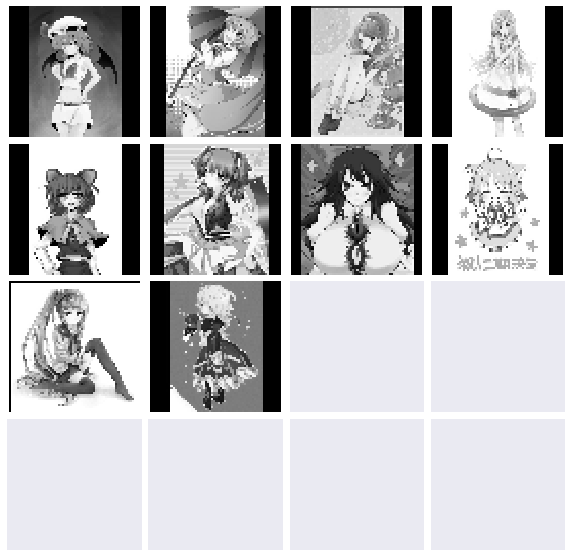

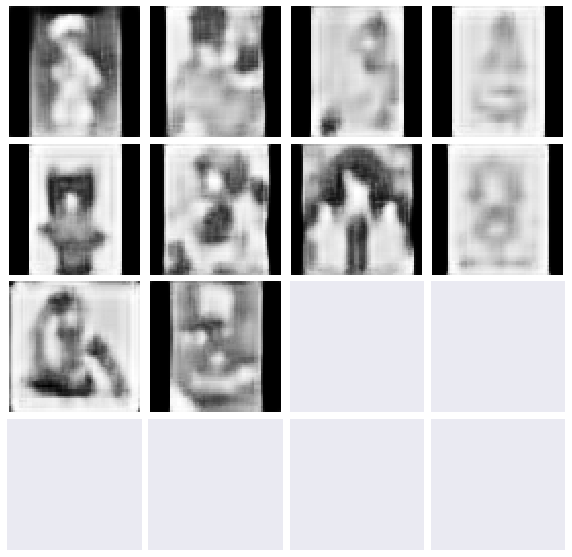

In [29]:
# Create reconstructions  
# get batch
test_batch = next(test_batch_generator)

# show the test images
show_images(test_batch, n_channels, resize_dim)

# create reconstructions
reconstructions = autoencoder.predict(test_batch)

# show the reconstructioned test images
show_images(reconstructions, n_channels, resize_dim)

## 5. Apply model to a real image

C:\Users\Admin\Anaconda3\envs\jupyter\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


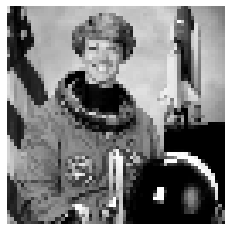

In [30]:
# grab an image
transfer_image = data.astronaut()

# resize the image and put it into gray scale
resized_transfer_image = gray_scale_resize(transfer_image, resize_dim)

# batch it
reshaped_transfer_image = resized_transfer_image.reshape(-1, resize_dim, resize_dim, 1)

# display an image
show_image(resized_transfer_image, 1, resize_dim)

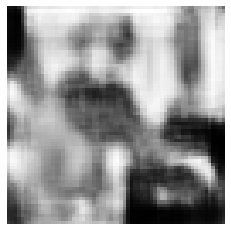

In [31]:
# run the image through the model
test_y = autoencoder.predict(reshaped_transfer_image)

# view the resulting image
show_image(test_y, n_channels, resize_dim)